# Lever

### Introduction

### What is it?

### Example

# Simulation

### Installing packages (for Google Colab)

If this notebook is opened in Google Colab then some packages must be installed to run the code!

In [1]:
#@title Run to install MuJoCo and `dm_control` for Google Colab

IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
    import distutils.util
    import os
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
            "file_format_version" : "1.0.0",
            "ICD" : {
                "library_path" : "libEGL_nvidia.so.0"
            }
        }
        """)

    print('Installing dm_control...')
    !pip install -q dm_control>=1.0.22

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl 

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    !echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

    # Graphics and plotting.
    print('Installing mediapy:')
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
    !pip install -q mediapy

    !git clone https://github.com/commanderxa/extraphi.git

## Import

Import all required packages to preform simulations. Packages include simulation engine, plotting libraries and other ones necessary for computations.

In [2]:
%env MUJOCO_GL=egl

import os

# simulation
from dm_control import mjcf, mujoco
from dm_control.mujoco.wrapper.mjbindings import enums

# for video recording
import mediapy

# computations
import numpy as np

env: MUJOCO_GL=egl


## Initial Conditions

In this block constants are defined. They impact the environment, rendering and objects directly.

In [3]:
# global
viscosity = 0.00002  # Air Resistance

# simulation constants
mass = 10  # [kg]
length = 5  # [m]
force = -50  # [N]
middle = 0.5 # [fraction in [0, 1]]

# rendering
width = 1280
height = 720
dpi = 600
duration = 10  # (seconds)
framerate = 60  # (Hz)

# project related
unit = os.getcwd().split("/")[-1]  # get the current directory
section = os.getcwd().split("/")[-2]  # get the current directory

## Model

### Scene

Import scene from `mechanics/scene.py`. The code is a bit difficult due to the import from parent directories.

In [4]:
import os, sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from scene import Scene

### Objects of Interest

This class defines the object of our interest, a `box`. Here we write what is this object (box), what can it do (move, fall, rotate) and also add a camera that follows the object.

In [5]:
class Box(object):

    def __init__(self, name: str, mass: float, size: float, rgba: list[float]) -> None:
        self.model = mjcf.RootElement(model=name)

        self.box = self.model.worldbody.add("body", name="box", pos=[0, 0, 0])
        self.box_geom = self.box.add(
            "geom",
            name="box_geom",
            type="box",
            size=[size, size, size],
            mass=mass,
            rgba=rgba,
            condim=6,
            friction=[1.0],
        )

        self.model.actuator.add(
            "adhesion",
            name=f"{name}_adhesion",
            body="box",
            ctrlrange=[0, 1],
            gain=10,
        )

        self.fall = self.box.add("joint", name="fall", type="slide", axis=[0, 0, 1])
        self.move = self.box.add("joint", name="move", type="slide", axis=[1, 0, 0])
        self.rotate = self.box.add("joint", name="rotate", type="hinge", axis=[0, 1, 0])

In [6]:
class Lever(object):

    def __init__(self, length: float, middle: float, mass: float) -> None:
        self.model = mjcf.RootElement(model="lever")

        self.lever_body = self.model.worldbody.add(
            "body", name="lever_body", pos=[0, 0, 0]
        )

        self.leg_length = 0.4
        self.base_leg_1 = self.lever_body.add(
            "geom",
            name="base_leg_1",
            type="box",
            size=[self.leg_length, self.leg_length, 0.02],
            rgba=[1, 1, 0, 1],
            euler=[0, 75, 0],
            pos=[
                np.sin(np.deg2rad(15)) * self.leg_length,
                0,
                np.sin(np.deg2rad(75)) * self.leg_length,
            ],
            conaffinity=2,
            contype=2,
        )
        self.base_leg_2 = self.lever_body.add(
            "geom",
            name="base_leg_2",
            type="box",
            size=[self.leg_length, self.leg_length, 0.02],
            rgba=[1, 1, 0, 1],
            euler=[0, -75, 0],
            pos=[
                np.sin(np.deg2rad(-15)) * self.leg_length,
                0,
                np.sin(np.deg2rad(75)) * self.leg_length,
            ],
            conaffinity=2,
            contype=2,
        )

        self.wrapper = self.lever_body.add(
            "body",
            name="lever_wrapper",
            pos=[0, 0, np.sin(np.deg2rad(75)) * self.leg_length * 2],
        )

        self.half_length = length / 2

        self.line = self.wrapper.add(
            "geom",
            name="line",
            type="box",
            size=[self.half_length, 0.5, 0.05],
            rgba=[1, 0.1, 0.2, 1],
            pos=[self.half_length - middle * length, 0, 0],
            condim=6,
            friction=[1.0],
        )

        box_size = 0.7 / 2
        self.box = Box(name="box", mass=mass, size=box_size, rgba=[0.2, 0.3, 1, 1])
        self.box_site = self.lever_body.add(
            "site",
            rgba=[0, 0, 0, 0],
            pos=[
                self.half_length - middle * length + self.half_length - box_size,
                0,
                np.sin(np.deg2rad(75)) * self.leg_length * 2 + box_size,
            ],
        )
        self.box_site.attach(self.box.model)

        self.hidden_box = Box(
            name="hidden_box", mass=1, size=box_size, rgba=[0, 0, 0, 0.3]
        )
        self.hidden_site = self.lever_body.add(
            "site",
            rgba=[0, 0, 0, 0],
            pos=[
                self.half_length - middle * length + -self.half_length + box_size,
                0,
                np.sin(np.deg2rad(75)) * self.leg_length * 2 + box_size,
            ],
        )
        self.hidden_site.attach(self.hidden_box.model)

        self.rotate = self.wrapper.add(
            "joint", name="rotate", type="hinge", axis=[0, 1, 0]
        )

### World Model

Collecting everything into one general model.

In [7]:
class Model(object):

    def __init__(self, length: float) -> None:
        self.model = mjcf.RootElement(model="lever_physics")

        # set render info
        self.model.visual.__getattr__("global").offheight = height
        self.model.visual.__getattr__("global").offwidth = width

        # set the simulation constants
        self.model.option.viscosity = viscosity
        self.model.option.integrator = "RK4"
        self.model.option.timestep = 0.0001

        self.length = length

        # create the environment (ground)
        self.scene = Scene(length=length * 3)
        self.scene_site = self.model.worldbody.add("site", pos=[0, 0, 0])
        self.scene_site.attach(self.scene.model)

        self.lever = Lever(length, middle, mass)
        self.lever_site = self.model.worldbody.add("site", pos=[0, 0, 0])
        self.lever_site.attach(self.lever.model)

        self.camera = self.model.worldbody.add(
            "camera",
            name="front",
            pos=[length / 2 - middle * length, -length, length / 2],
            euler=[75, 0, 0],
        )

## Simulation

Initializing the `physics` of the simulation.

In [8]:
model = Model(length=length).model
physics = mjcf.Physics.from_mjcf_model(model)

Setting some engine flags. In this case, we want to see all joint that are present.

In [9]:
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True

First of all, the environment must be verified by rendering a picture.

""

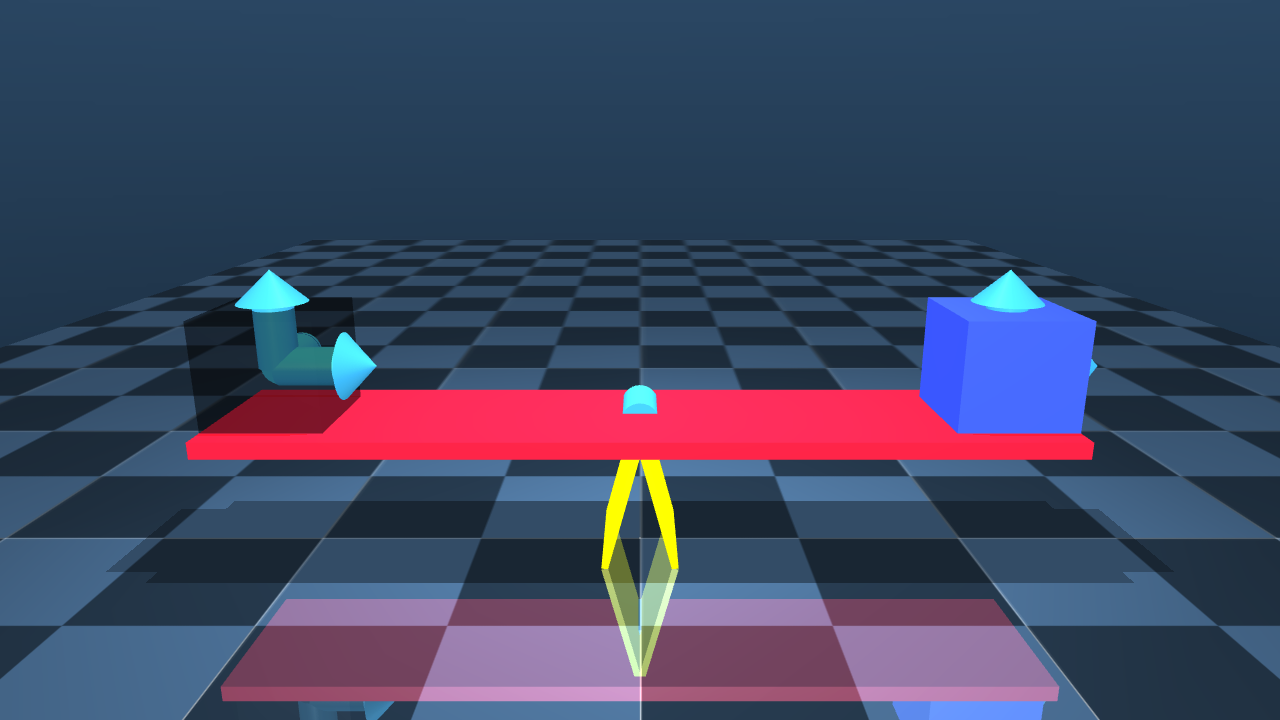

In [10]:
mediapy.show_image(
    physics.render(height, width, camera_id=0, scene_option=scene_option)
)

### Simulation Loop

In [11]:
frames = []
timevals = []
velocity = []
position = []

physics.bind(model.find_all("actuator")).ctrl = [1, 1]

while physics.data.time < duration:
    physics.named.data.xfrc_applied["lever/hidden_box/box"][2] = (
        force + abs(physics.model.opt.gravity[-1])
    )
    physics.step()

    timevals.append(physics.data.time)
    # velocity.append(physics.named.data.qvel["box/move"][0].copy())
    # position.append(physics.named.data.geom_xpos["box/box_geom"][0].copy())

    if len(frames) < physics.data.time * framerate:
        pixels = physics.render(width=width, height=height, camera_id=0)
        frames.append(pixels)

In [12]:
mediapy.show_video(frames, fps=framerate)

Save the rendered video

In [13]:
mediapy.write_video(f"../../output/lever.mp4", images=frames, fps=framerate)